<a href="https://colab.research.google.com/github/tensorflow-project/FineTuning/blob/main/Experiments/deleteMetraining_two_concepts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
get_ipython().system('pip install -q git+https://github.com/keras-team/keras-cv.git')
get_ipython().system('pip install -q tensorflow==2.11.0')
get_ipython().system('pip install pyyaml h5py')

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 90.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!git clone https://github.com/tensorflow-project/FineTuning

Cloning into 'FineTuning'...
remote: Enumerating objects: 1981, done.
remote: Counting objects: 100% (944/944), done.
remote: Compressing objects: 100% (336/336), done.
remote: Total 1981 (delta 704), reused 821 (delta 603), pack-reused 1037
Receiving objects: 100% (1981/1981), 177.93 MiB | 23.05 MiB/s, done.
Resolving deltas: 100% (1423/1423), done.
Updating files: 100% (40/40), done.


In [3]:
import sys
import os
import numpy as np
from google.colab import drive
import keras
import keras_cv
import tensorflow as tf

### agree to mounting your Google Drive
drive.mount("/content/drive")

py_file_location = "/content/FineTuning/two_concepts"
sys.path.append(os.path.abspath(py_file_location))
py_file_location = "/content/FineTuning/models"
sys.path.append(os.path.abspath(py_file_location))

import textual_inversion_two_concepts as txt

Mounted at /content/drive
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
### create an instance of the Stable Diffusion model
stable_diffusion = txt.StableDiffusion()

### our new concept which is later inserted in the different prompts (for training and image generation)
placeholder_token_broccoli = "<my-broccoli-token>"
placeholder_token_emoji = "<my-emoji-token>"
placeholder_token_combined = "<my-broccoli-emoji-token>"

train_ds = txt.create_dataset(stable_diffusion, placeholder_token_broccoli, placeholder_token_emoji)

txt.textual_preprocessing(stable_diffusion, placeholder_token_broccoli, placeholder_token_emoji, placeholder_token_combined)

### put all the different components of stable diffusion model into a list
"""all_models = [
    stable_diffusion.text_encoder,
    stable_diffusion.diffusion_model,
    stable_diffusion.decoder,
]"""



### beta is the diffusion rate
noise_scheduler = txt.NoiseScheduler(
    ### beta_start determines the amount of noise added at the start of the denoising process
    beta_start=0.00085,
    ### beta_end at the end of the denoising process
    beta_end=0.012,
    ### the beta_schedule determines that the diffusion rate increases linearly
    beta_schedule="scaled_linear",
    train_timesteps=1000,
)

### Initialize the model we use to fine tune our concept
trainer = txt.StableDiffusionFineTuner(stable_diffusion, noise_scheduler, name="trainer")
#t = txt.StableDiffusionFineTuner(stable_diffusion, noise_scheduler, name="t")


#EPOCHS = 50
### learning rate decays depending on the number of epochs to avoid convergence issues in few epochs 
### in the originial tutorial a scheduler is used but we experienced to have better results without a scheduler
"""learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4, decay_steps=train_ds.cardinality() * EPOCHS
)"""
### inizialize the optimizer
optimizer = tf.keras.optimizers.Adam(
    weight_decay=0.004, learning_rate=1e-4, epsilon=1e-8, global_clipnorm=10
)

trainer.compile(
    optimizer=optimizer,
    # We are performing reduction manually in our train step, so none is required here.
    loss=keras.losses.MeanSquaredError(reduction="none"),
)  

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
13911/13911 [==============================] - 0s 0us/step


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


136824240/136824240 [==============================] - 1s 0us/step


In [5]:
### EXECUTE THE FOLLOWING TWO BLOCKS ONLY IF YOU WANT TO CONTINUE TRAINING WITH SAVED WEIGTHS
### choose where to load the weights from, either from your google drive or you load our pretrained weights
### make sure to insert the exact name of your weight.npy
path = '/content/drive/MyDrive/1weights_with_two_concepts.npy'

In [ ]:
###load the array of the weights of the text encoder from the training
text_encoder_weights = np.load(path, allow_pickle=True)

### Set the weights of the text encoder
stable_diffusion.text_encoder.set_weights(text_encoder_weights)

FileNotFoundError: ignored

In [6]:
### training
trainer.fit(
    train_ds,
    epochs=1,
)

220/220 [==============================] - 457s 2s/step - loss: 0.0655


25/25 [==============================] - 83s 3s/step


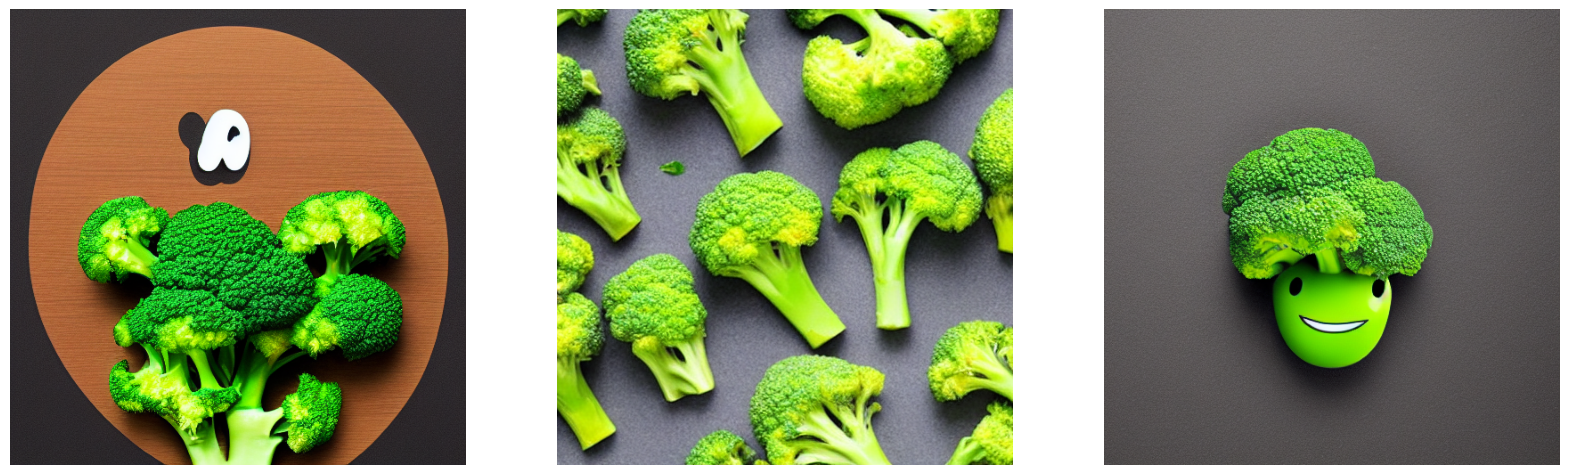

In [7]:


### generate some examples and plot them according to our new concept and prompts
### with the combined tokens
generated = stable_diffusion.text_to_image(
    f" a {placeholder_token_broccoli} with {placeholder_token_emoji}", batch_size = 3, num_steps = 25, seed=2332
)
txt.plot_images(generated)
     


31/31 [==============================] - 79s 3s/step


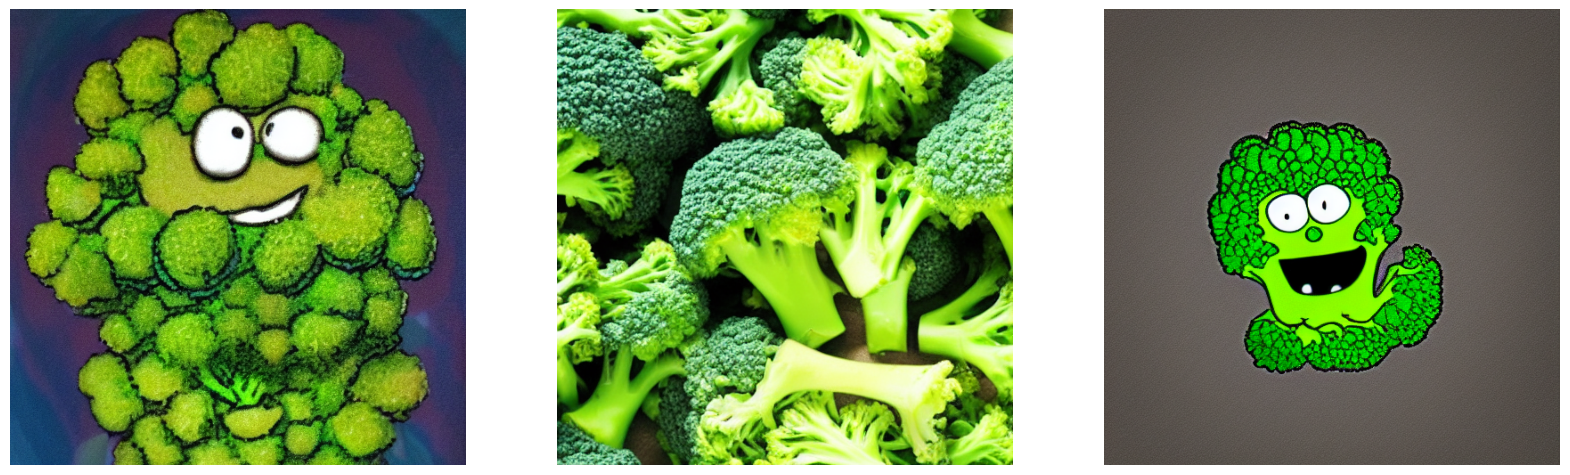

In [8]:


### choose how much of an emoji your broccoli sticker should include
percent = 0.3

### generate some examples and plot them according to our new concept and prompts
### with token interpolation
generated = stable_diffusion.text_to_image(
    f"A happy {placeholder_token_combined}. ", batch_size = 3, num_steps = 30, seed=2332
)
txt.plot_images(generated)
     


In [ ]:
### choose where to save your newly generated weights
path = '/content/drive/MyDrive/weight_with_two_concepts.npy'

In [ ]:
###get the weights of the text encoder and save the to Google Drive
text_encoder_weights = np.array(stable_diffusion.text_encoder.get_weights(), dtype=object)

### Save the weights array to a file on your Google Drive
np.save(path, text_encoder_weights)